# Guidelines for creating a basic machine learning model

With scikit learn and python 3! Mostly this notebook is showing how to use my machine learning helper functions in `ml_helper.py`

I downloaded the [student alchohol consumption](https://www.kaggle.com/uciml/student-alcohol-consumption) maths student (yes MATHS) dataset from Kaggle. Let's pretend we are tasked with answering the question:

Which students are likely to consume high levels of alcohol? And the answer is not just "the fun ones".



## Choose features to go into the model

Pick features that you expect will have a strong impact on the variable you are trying to predict. For a first iteration, keep these as simple as possible. Don't get too clever at first with "feature engineering" e.g. by combining different features together (calculating new fields), or by including too many things that won't obviously have a strong impact and might take a lot of munging because of missing data or weird data types.

Depending on the question you are trying to answer, you may need to "engineer" both the inputs to the model *and* the outputs the model is trying to predict. For example in this case, how should we define "consumes high level of alcohol"?

To help you choose, make plots to see what the distributions of the different variables look like, and always bother to justify why you did something, or at least look like you thought about why it was best (or the least worst) thing to do at the time.

In [29]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# my own code
import ml_helper as mlhelp

%matplotlib inline
sns.set_style("white")


student_mat = pd.read_csv('student-mat.csv')

In [30]:
student_mat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [31]:
student_mat.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

## Deal with missing data

None here!

But if there was, here are some ways to deal with a variable that has missing value for some samples:

* if data is continuous (float or integer)
    * fill in missing values with the average of all the non-missing values (easy)
    * take the samples that don't have missing values, and cluster them together (using their other variables). Find the average value of the variable with the missing data from samples within each cluster. Depending on which cluster samples that have missing values lie in, assign them the average value of that variable for their cluster.
* if data is categorical
    * fill in with the most common category (bad)
    * do a clustering similar to above, and fill with the most common category in that cluster
    * make an extra category called the "no data" category: sometimes the fact there is "no data" gives information about the problem (it may indicate something not happening, or having not happened yet) 
* if there are very few samples and the variable is probably not all that important
    * drop the mother

In [32]:
# No missing data so we have an easy time
len(student_mat), len(student_mat.dropna())

(395, 395)

## The output variable to classify

We have two variables that can define "high alcohol consumption": workday and weekend alcohol consumption that go from 1 (very low) to 5 (very high).

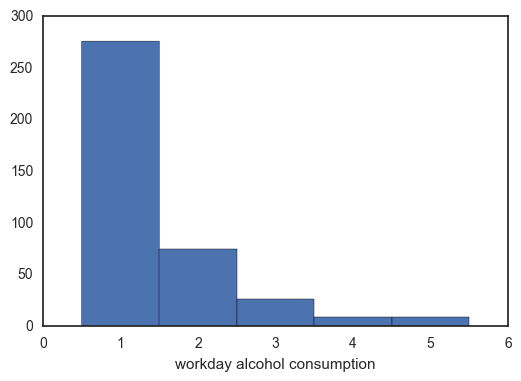

In [33]:
plt.hist(student_mat['Dalc'], bins=np.arange(0.5, 5.6))
plt.xlabel('workday alcohol consumption');

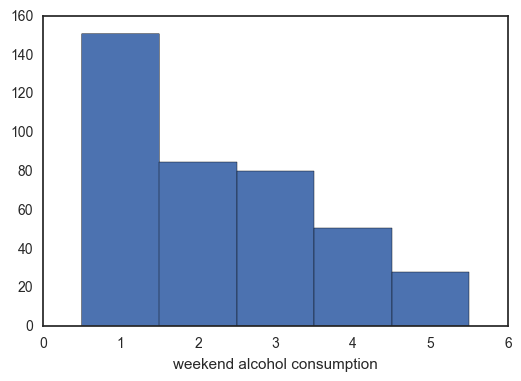

In [34]:
plt.hist(student_mat['Walc'], bins=np.arange(0.5, 5.6))
plt.xlabel('weekend alcohol consumption');

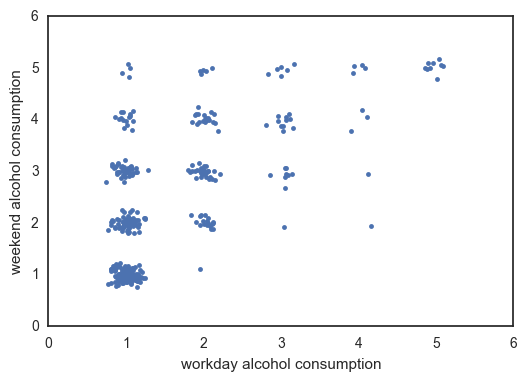

In [35]:
# add a little random noise to the integers to get an idea of number of point in each combo
plt.figure()
plt.plot(student_mat['Dalc']+ 0.1*np.random.randn(len(student_mat['Walc'])), 
         student_mat['Walc']+0.1*np.random.randn(len(student_mat['Walc'])), '.')
plt.xlabel('workday alcohol consumption')
plt.ylabel('weekend alcohol consumption')

In [36]:
student_mat.groupby('Dalc').apply(lambda x: x['Walc'].describe())

Walc,count,mean,std,min,25%,50%,75%,max
Dalc,,,,,,,,
1,276.0,1.760870,0.994928,1.0,1.0,1.0,2.0,5.0
2,75.0,3.160000,0.915925,1.0,2.5,3.0,4.0,5.0
3,26.0,3.846154,0.833897,2.0,3.0,4.0,4.0,5.0
4,9.0,4.111111,1.054093,2.0,4.0,4.0,5.0,5.0
5,9.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0


In [37]:
student_mat.groupby('Walc').apply(lambda x: x['Dalc'].describe())

Dalc,count,mean,std,min,25%,50%,75%,max
Walc,,,,,,,,
1,151.0,1.006623,0.081379,1.0,1.0,1.0,1.0,2.0
2,85.0,1.270588,0.543100,1.0,1.0,1.0,1.0,4.0
3,80.0,1.600000,0.722163,1.0,1.0,1.0,2.0,4.0
4,51.0,2.039216,0.870880,1.0,1.0,2.0,3.0,4.0
5,28.0,3.321429,1.467009,1.0,2.0,3.0,5.0,5.0


Totally arbitrarily I will define a "high alchohol consumption" to be students who have a workday alcohol consumption of 3 or above and a weekend alcohol consumption of 5.

We could also take the student's age into account for under 21 vs over 21.

Note that the binary classes are unbalanced.

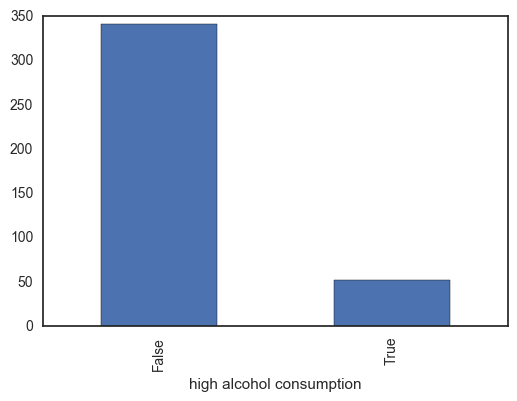

In [38]:
student_mat['high_alcohol'] = (student_mat['Dalc']>=3) | (student_mat['Walc']==5)

fig = plt.figure()
ax = fig.add_subplot(111)
student_mat.groupby('high_alcohol').size().plot(kind='bar', ax=ax)
ax.set_xlabel('high alcohol consumption')

## The input variables


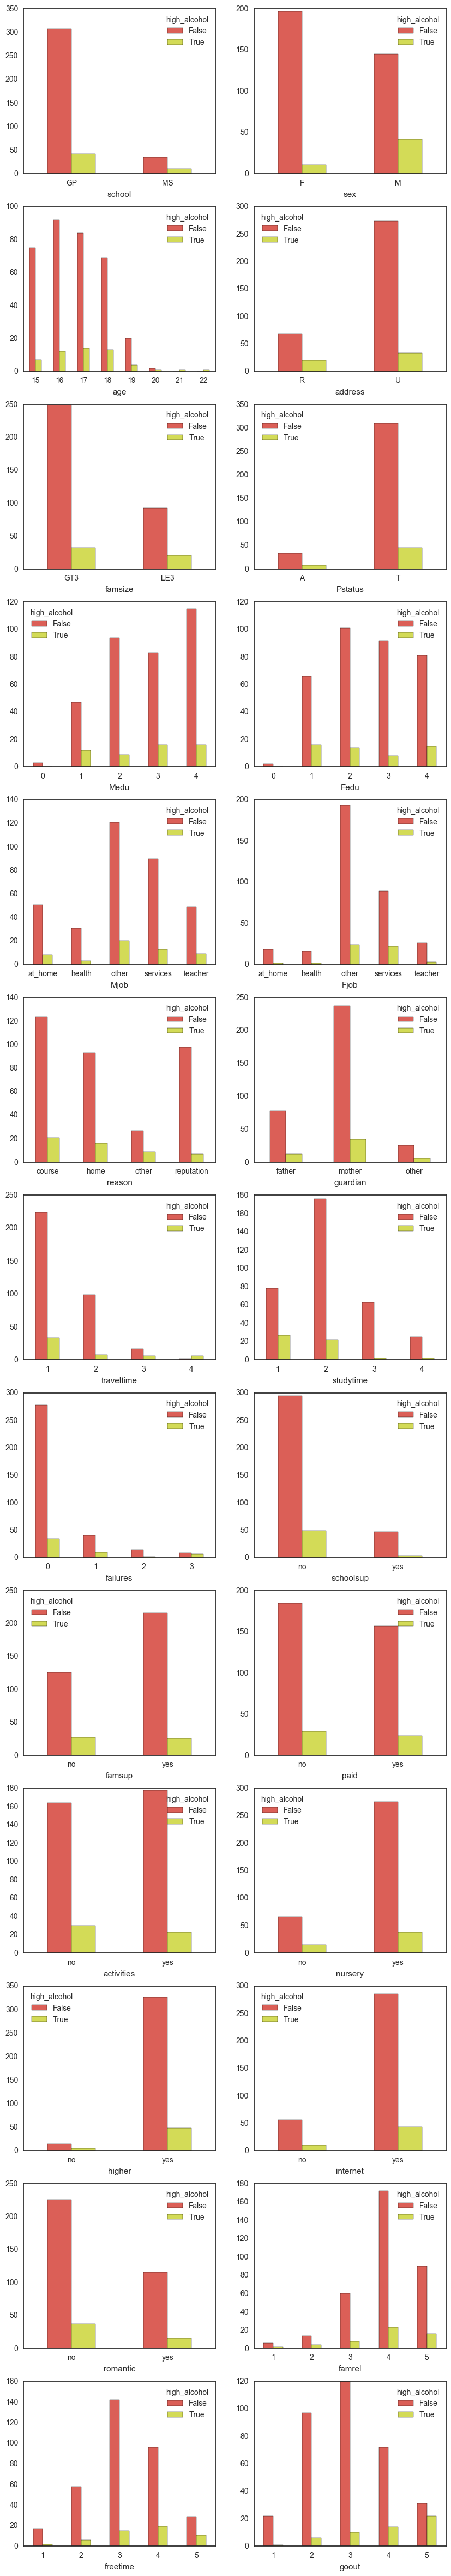

In [39]:

inputs = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout']

fig = plt.figure(figsize=(10,60))

for i, col in enumerate(inputs):
    ax = fig.add_subplot(13,2,i+1)

    grouped = student_mat.groupby(["high_alcohol", col]).size().unstack("high_alcohol").fillna(0)
    grouped.plot(kind='bar', stacked=False, ax=ax, color=sns.color_palette('hls'))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    ax.set_xlabel(col)

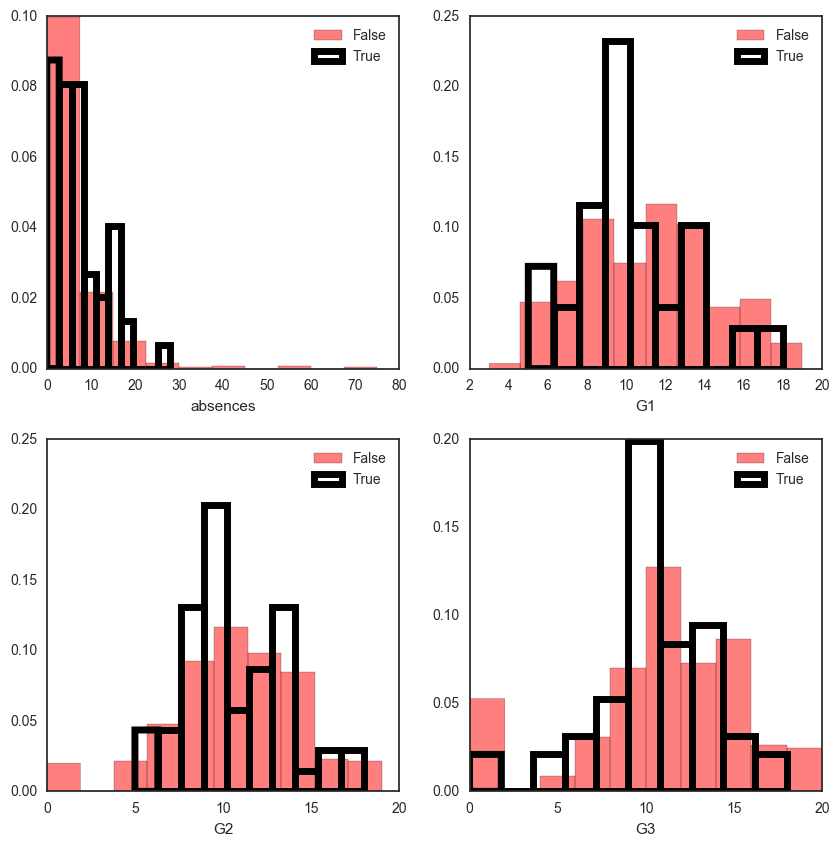

In [40]:
inputs = ['absences', 'G1', 'G2', 'G3']

fig = plt.figure(figsize=(10,10))

for i, col in enumerate(inputs):
    
    ax = fig.add_subplot(2,2, i+1)
    ax.hist(student_mat.loc[student_mat['high_alcohol']==False, col], label='False', 
            normed=True, color='red', alpha=0.5)
    ax.hist(student_mat.loc[student_mat['high_alcohol']==True, col], label='True', 
            normed=True, facecolor='none', edgecolor='black', linewidth=5)
    ax.set_xlabel(col)
    ax.legend()

## Base model

Logistic Regression is one of the simplest models you can use. It's great because the model is interpretable: the size and sign of the coefficients of each feature show how important the feature is and also how it influences the predicted outcome (positively or negatively correlated).

Logistic regression is also sensitive to feature scaling: it may not perform well if the features are on vastly different scales. It's usually best to always rescale features to be standard normals or to something like max(val) - min(val) divided by the range in values.

However its performance (at least without extending it to have polynomial terms and combining features in an ad hoc and complicated way) is not as good as more sophisticated models but it's nice to use to get a baseline with.

First we don't optimise the regularisation parameter, and we'll just throw everything into the model.

In [41]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split # for scikit-learn 0.17



feature_columns = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 
                   'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime','failures', 
                   'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 
                   'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G1', 'G2', 'G3']

# this creates a list of dictionaries 
# each entry in the list is one of the students
# each key in their dictionary are their "feature": value
features = mlhelp.make_normal_features(student_mat, feature_columns)

# this puts the features into a DictVectorizer (dv)
# it also MaxAbs scales the feature values (mabs) using MaxAbsScaler
# DictVectorizer is useful for when you have 1000's of features, many of which are not defined for most samples
# It's un-neccessary here
# It turns all features that have str type values into one-hot encoding
column_to_predict = 'high_alcohol'
X, y, dv, mabs = mlhelp.create_data_for_model(student_mat, features, column_to_predict)

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, 
                                                      stratify=y, random_state=2016)

# So we noted before that our classes are not balanced
# Let's get sklearn to re-weight them for us to take account of that
# set class_weight='balanced'
learner = LogisticRegression(class_weight='balanced')
learner.fit(X_train, y_train)

# the predicted class assuming threshold probabilities= 0.5
y_predict = learner.predict(X_test)

# the probabilties of being class 0 or class 1 (threshold probability tbc)
y_probs = learner.predict_proba(X_test)

In [42]:
# The raw accuracy
mlhelp.classification_accuracy(y_predict, y_test);

Percentage correct predictions = 77.22
Percentage correct predictions (true class 0) = 91.67
Percentage correct predictions (true class 1) = 31.58


In [43]:
Xv = {'X_test': X_test, 'X_train': X_train}
yv = {'y_test': y_test, 'y_train': y_train}
metrics = mlhelp.print_cross_validation_metrics(Xv, yv, learner)

No cross-validation done on learner
Train roc_auc: 0.90328
Test roc_auc: 0.71791
Summary statistics
           accuracy  f1_score  precision    recall
threshold                                         
0.1        0.405063  0.276923   0.166667  0.818182
0.2        0.582278  0.326531   0.210526  0.727273
0.3        0.632911  0.355556   0.235294  0.727273
0.4        0.683544  0.324324   0.230769  0.545455
0.5        0.772152  0.400000   0.315789  0.545455
0.6        0.822785  0.461538   0.400000  0.545455
0.7        0.860759  0.476190   0.500000  0.454545
0.8        0.873418  0.375000   0.600000  0.272727
0.9        0.873418  0.285714   0.666667  0.181818


## Mini-cross validation with LogisticRegressionCV

The class LogisticRegressionCV chooses the best regularisation parameter via cross-validation without you having to think too much. By default it tries a grid of ten values in a logarithmic scale between 1e-4 and 1e4.



In [44]:
lrcv = LogisticRegressionCV(scoring='roc_auc', class_weight='balanced')
lrcv.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

In [45]:
# The default value was C=1
lrcv.C_

array([ 0.04641589])

In [46]:
# Try again with the better regularisation parameter
learner = LogisticRegression(class_weight='balanced', C=lrcv.C_[0])
learner.fit(X_train, y_train)
y_test_predict = learner.predict(X_test)
y_test_probs = learner.predict_proba(X_test)

mlhelp.classification_accuracy(y_test_predict, y_test);



Percentage correct predictions = 72.15
Percentage correct predictions (true class 0) = 91.07
Percentage correct predictions (true class 1) = 26.09


It's actually worse for the raw accuracy, but then the raw accuracy is assuming threshold = 0.5 and the cross-validation has optimised the ROC-AUC.

In [47]:
Xv = {'X_test': X_test, 'X_train': X_train}
yv = {'y_test': y_test, 'y_train': y_train}
metrics = mlhelp.print_cross_validation_metrics(Xv, yv, learner)

No cross-validation done on learner
Train roc_auc: 0.86331
Test roc_auc: 0.72460
Summary statistics
           accuracy  f1_score  precision    recall
threshold                                         
0.1        0.139241  0.244444   0.139241  1.000000
0.2        0.202532  0.258824   0.148649  1.000000
0.3        0.481013  0.305085   0.187500  0.818182
0.4        0.620253  0.347826   0.228571  0.727273
0.5        0.721519  0.352941   0.260870  0.545455
0.6        0.822785  0.300000   0.333333  0.272727
0.7        0.873418  0.285714   0.666667  0.181818
0.8        0.848101  0.000000   0.000000  0.000000
0.9        0.860759  0.000000   0.000000  0.000000


/Users/alexabate/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


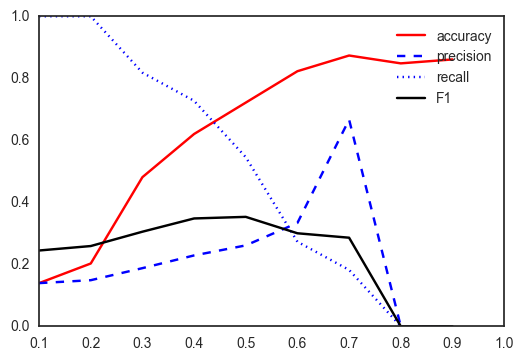

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)

mlhelp.plot_metrics(metrics, ax)
ax.legend(loc='upper right')

In [53]:
thresh_best = mlhelp.choose_best_threshold(metrics, metric_to_optimise='accuracy')
print('Best threshold =', thresh_best)

Best threshold = 0.7


In [54]:
y_test_probs_predict = np.zeros(y_test.shape)
y_test_probs_predict[y_test_probs[:,1]>thresh_best] = 1
mlhelp.classification_accuracy(y_test_probs_predict, y_test);

Percentage correct predictions = 87.34
Percentage correct predictions (true class 0) = 88.16
Percentage correct predictions (true class 1) = 66.67


In [62]:
mlhelp.print_features_importances(learner, dv, max_print=10)

goout 0.484272752075
sex=M 0.451575384763
address=R 0.264039350957
failures 0.256735201455
famsize=LE3 0.256063917537
reason=other 0.193998010955
nursery=no 0.179761128199
Fjob=services 0.1561392691
paid=yes 0.13993860553
Pstatus=A 0.136730071812
Mjob=other 0.116098595683


So the top predictors so far are:

* goes out with friends a lot
* gender = male
* lives in a rural area
* has larger number of class failures
* comes from a small family (<3)

But with AUC~0.72 this model is not very good!

## Cross-validation via grid search for random forest

Random forests are more fun because you don't have to worry about feature scaling much or much regularisation.

When in doubt: "throw it in a random forest"

They can deal with non-linear relationships in the data, so are automatically a better choice than linear/logistic regression for making a more accurate model.

However you lose some interpretability, although sklearn returns the "feature_importances"

In [76]:
# Define the grid of hyper-parameters to seach over
grid_search_params = {'n_estimators' : [10, 100, 500],
                      'max_depth' : [2, 5, 10, 20],
                      'min_samples_leaf' : [1, 5, 10, 20]}

learner = RandomForestClassifier(class_weight='balanced')

gs = mlhelp.gridded_cv_fit(X_train, y_train, grid_search_params, learner)

In [77]:
gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}

In [78]:
metrics = mlhelp.print_cross_validation_metrics(Xv, yv, gs)

Best cross-validation roc_auc: 0.78657
Train roc_auc: 0.95342
Test roc_auc: 0.79144
Summary statistics
           accuracy  f1_score  precision    recall
threshold                                         
0.1        0.139241  0.244444   0.139241  1.000000
0.2        0.227848  0.265060   0.152778  1.000000
0.3        0.569620  0.346154   0.219512  0.818182
0.4        0.759494  0.424242   0.318182  0.636364
0.5        0.848101  0.500000   0.461538  0.545455
0.6        0.873418  0.285714   0.666667  0.181818
0.7        0.860759  0.000000   0.000000  0.000000
0.8        0.860759  0.000000   0.000000  0.000000
0.9        0.860759  0.000000   0.000000  0.000000


/Users/alexabate/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


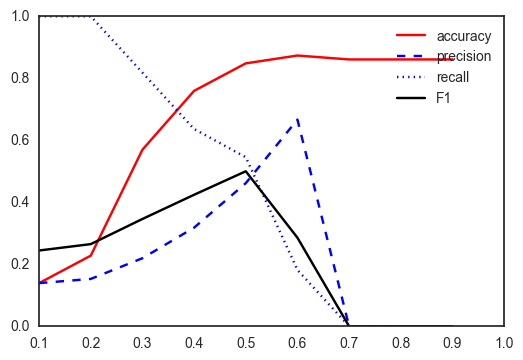

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)

mlhelp.plot_metrics(metrics, ax)
ax.legend(loc='upper right')

In [80]:
thresh_best = mlhelp.choose_best_threshold(metrics, metric_to_optimise='accuracy')
print('Best threshold =', thresh_best)

Best threshold = 0.6


In [81]:
y_test_probs_predict = np.zeros(y_test.shape)
y_test_probs_predict[y_test_probs[:,1]>thresh_best] = 1
mlhelp.classification_accuracy(y_test_probs_predict, y_test);

Percentage correct predictions = 82.28
Percentage correct predictions (true class 0) = 88.57
Percentage correct predictions (true class 1) = 33.33


In [82]:
mlhelp.print_features_importances(gs.best_estimator_, dv, max_print=10)

goout 0.1075600946
sex=F 0.105625373532
sex=M 0.0912237675326
absences 0.0816360385759
G3 0.0404376935714
G1 0.0392724064133
studytime 0.0340516356481
famsize=LE3 0.0300200955575
G2 0.0280321431671
traveltime 0.0253075031069
failures 0.0236489490382


Interestingly the important features shift around a bit for the random forest. The overall accuracy looks worse but the ROC-AUC is better. 

Finally, deciding on how "good" your model is depends on the business case. Is accuracy, precision or recall more important? You will need to justify your choice of classification threshold based upon one or more of these.

In summary: we built some shitty models here, but I hope it illustrates the main points to hit/consider when building a machine learning model.

If we went back and tweaked the features, removing some and/or combining some hopefully we could build a decent model.